#Этот ноутбук проводит анализ мультимодальной модели [ViLT](https://huggingface.co/dandelin/vilt-b32-finetuned-vqa) с помощью Logit Lens-подхода:

 * Выясняем, как модель изменяет предсказания по слоям.
 * Отслеживаем «логит-джампы» — резкие изменения вероятностей.
 * Понимаем, на каком слое модель начинает «понимать» визуальный и текстовый контекст.
 * Строим графики и таблицы эволюции вероятностей для ключевых классов.
 * Выделяем, какие признаки и действия выявляются моделью на ранних и поздних слоях.



 ## Для запуска достаточно просто постепенно идти по ноутбуку, все подтягивается/устанавливается само

In [2]:
import torch
import torch.nn.functional as F
from transformers import ViltProcessor, ViltForQuestionAnswering
from PIL import Image
import requests
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import pandas as pd

In [3]:
#Этот блок определяет основной класс LogitLensViLT, реализующий:

# * Загрузку модели и процессора.
# * Прямой проход с сохранением hidden_states.
# * Применение классификатора на каждом скрытом слое (Logit Lens).
# * Извлечение топ-ответов и вероятностей.

class LogitLensViLT:
    def __init__(self, model_name, model_class, processor_class):
        self.model = model_class.from_pretrained(model_name, output_hidden_states=True)
        self.processor = processor_class.from_pretrained(model_name)
        self.model.eval()
        self.label_map = self.model.config.id2label

    def prepare_inputs(self, image, text):
        inputs = self.processor(image, text, return_tensors="pt")
        return inputs

    def forward_with_hidden(self, image, text):
        inputs = self.prepare_inputs(image, text)
        with torch.no_grad():
            outputs = self.model(**inputs)
        return outputs.hidden_states, outputs.logits, inputs

    def run_logit_lens(self, image, text):
        hidden_states, _, _ = self.forward_with_hidden(image, text)
        lens_probs = []
        for h in hidden_states:
            cls_rep = h[:, 0, :]
            logits = self.model.classifier(cls_rep)
            probs = F.softmax(logits, dim=-1).squeeze()
            lens_probs.append(probs)
        return lens_probs

    def get_top_preds(self, logits, top_k=5):
        probs = F.softmax(logits, dim=-1).squeeze()
        top_probs, top_ids = torch.topk(probs, top_k)
        top_ids = top_ids.flatten()
        tokens = [self.label_map[int(i)] for i in top_ids]
        probs_list = top_probs.tolist()
        return tokens, probs_list

In [4]:
#Здесь реализуются функции для:

# * Построения графиков вероятностей по слоям.
# * Поиска «логит-джампов» — резких приростов вероятности.
# * Вывода токенов с наибольшей уверенностью по слоям.
# * Визуализации изменения вероятностей между слоями.

def plot_logit_lens(lens_probs, label_map, target_labels, title="Logit Lens - Probability per Layer"):
    inv_label_map = {v.lower(): k for k, v in label_map.items()}
    token_ids = {}
    for label in target_labels:
        idx = inv_label_map.get(label.lower())
        if idx is not None:
          token_ids[label] = idx
    probs_by_layer = defaultdict(list)
    for probs in lens_probs:
        for label, idx in token_ids.items():
            if idx < probs.shape[-1]:
                probs_by_layer[label].append(probs[idx].item())
    plt.figure(figsize=(14, 7))
    for label, values in probs_by_layer.items():
        plt.plot(values, marker='o', label=label)
    plt.xlabel("Слой")
    plt.ylabel("Вероятность")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
    return probs_by_layer

def find_jumps(lens_probs, label_map, top_k=5, threshold=0.15):
    jumps = []
    num_classes = lens_probs[0].shape[-1]
    for class_idx in range(num_classes):
        values = [probs[class_idx].item() for probs in lens_probs]
        diffs = [values[i+1] - values[i] for i in range(len(values)-1)]
        max_jump = max(diffs) if diffs else 0
        max_jump_layer = diffs.index(max_jump) + 1 if max_jump > threshold else None
        if max_jump_layer:
            jumps.append((class_idx, max_jump, max_jump_layer))
    jumps.sort(key=lambda x: x[1], reverse=True)
    top_jumps = jumps[:top_k]
    result = [(label_map.get(idx, str(idx)), jump_val, layer) for idx, jump_val, layer in top_jumps]
    return result

def print_topk_per_layer(lens_probs, analyzer, top_k=5):
    print("\nДинамика топ признаков по слоям:")
    n_layers = len(lens_probs)
    for layer_idx in range(n_layers):
        probs = lens_probs[layer_idx]
        top_probs, top_ids = torch.topk(probs, top_k)
        top_ids = top_ids.flatten()
        tokens = [analyzer.label_map[int(i)] for i in top_ids]
        print(f"  Слой {layer_idx}:")
        for t, p in zip(tokens, top_probs.tolist()):
            print(f"    - {t}: {p:.4f}")

def plot_layer_deltas(lens_probs, target_labels, label_map):
    inv_label_map = {v.lower(): k for k, v in label_map.items()}
    target_indices = [inv_label_map[label.lower()] for label in target_labels if label.lower() in inv_label_map]
    deltas = {idx: [] for idx in target_indices}
    for i in range(len(lens_probs) - 1):
        curr_probs = lens_probs[i]
        next_probs = lens_probs[i+1]
        for idx in target_indices:
            delta = next_probs[idx].item() - curr_probs[idx].item()
            deltas[idx].append(delta)
    plt.figure(figsize=(12, 6))
    for idx in target_indices:
        label = label_map[idx]
        plt.plot(deltas[idx], marker='o', label=label)
    plt.title("Дельта вероятностей между слоями")
    plt.xlabel("Переход между слоями")
    plt.ylabel("Изменение вероятности")
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
# Основной блок, запускающий весь анализ:

# * Загружает изображение и формулирует вопрос.
# * Получает `hidden_states` и финальные логиты.
# * Строит визуализации, таблицы и графики.
# * Ищет резкие скачки вероятностей.
# * Выводит топ токенов по каждому слою.

def run_analysis():
    image_url = "https://cdn.creazilla.com/photos/1778092/free-stock-photo-of-dog-labrador-theme-dogs-photo-xl.jpeg"
    image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")

    plt.imshow(image)
    plt.axis('off')
    plt.title("Analyzed Image")
    plt.show()

    question = "What animal is in the picture?"

    analyzer_vqa = LogitLensViLT("dandelin/vilt-b32-finetuned-vqa", ViltForQuestionAnswering, ViltProcessor)

    print("=== Анализ VQA с использованием Logit Lens ===")
    hidden_states, final_logits, inputs = analyzer_vqa.forward_with_hidden(image, question)

    top_answers, top_probs = analyzer_vqa.get_top_preds(final_logits, top_k=5)
    print(f"\nВопрос: {question}")
    print("Топ-5 ответов и вероятности:")
    for ans, prob in zip(top_answers, top_probs):
        print(f"  - {ans}: {prob:.4f}")

    lens_probs = analyzer_vqa.run_logit_lens(image, question)

    plot_logit_lens(lens_probs, analyzer_vqa.label_map, top_answers, title="VQA: Вероятности топ-ответов по слоям")

    print_topk_per_layer(lens_probs, analyzer_vqa, top_k=5)
    jumps = find_jumps(lens_probs, analyzer_vqa.label_map, top_k=5, threshold=0.15)
    print("\nТоп резких скачков вероятностей (логит джампы):")
    for label, jump_val, layer in jumps:
        print(f"  - Класс '{label}': скачок {jump_val:.3f} на слое {layer}")

    plot_layer_deltas(lens_probs, top_answers, analyzer_vqa.label_map)

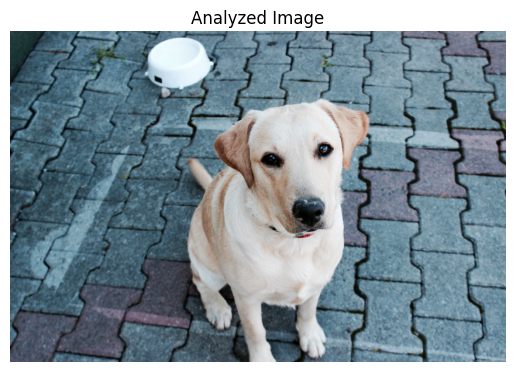

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/136k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/470M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/470M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

=== Анализ VQA с использованием Logit Lens ===

Вопрос: What animal is in the picture?
Топ-5 ответов и вероятности:
  - dog: 0.9995
  - yes: 0.0002
  - lab: 0.0001
  - 1: 0.0001
  - golden retriever: 0.0000


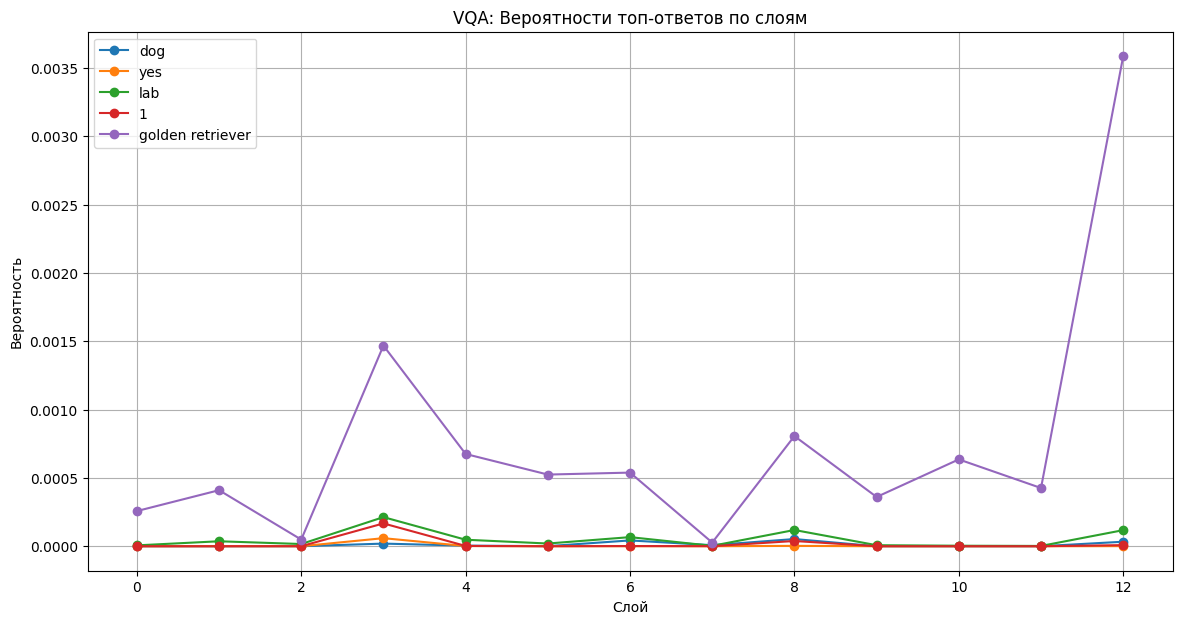


Динамика топ признаков по слоям:
  Слой 0:
    - siamese: 0.3830
    - slacks: 0.1986
    - german shepherd: 0.0733
    - calico: 0.0627
    - persian: 0.0577
  Слой 1:
    - slacks: 0.3411
    - siamese: 0.2046
    - tuxedo: 0.1124
    - persian: 0.0951
    - clydesdale: 0.0549
  Слой 2:
    - persian: 0.2229
    - tuxedo: 0.1996
    - siamese: 0.1942
    - bowtie: 0.1521
    - calico: 0.0570
  Слой 3:
    - persian: 0.2474
    - calico: 0.2044
    - siamese: 0.1184
    - clydesdale: 0.0497
    - tuxedo: 0.0466
  Слой 4:
    - persian: 0.3320
    - calico: 0.2509
    - siamese: 0.1129
    - tuxedo: 0.0349
    - deep: 0.0327
  Слой 5:
    - persian: 0.2970
    - siamese: 0.1796
    - calico: 0.1132
    - on suitcase: 0.0568
    - very deep: 0.0479
  Слой 6:
    - on suitcase: 0.2543
    - in suitcase: 0.1153
    - glazed: 0.0507
    - awake: 0.0477
    - licking: 0.0412
  Слой 7:
    - looking out window: 0.2499
    - licking: 0.1554
    - on suitcase: 0.1165
    - awake: 0.0917
    -

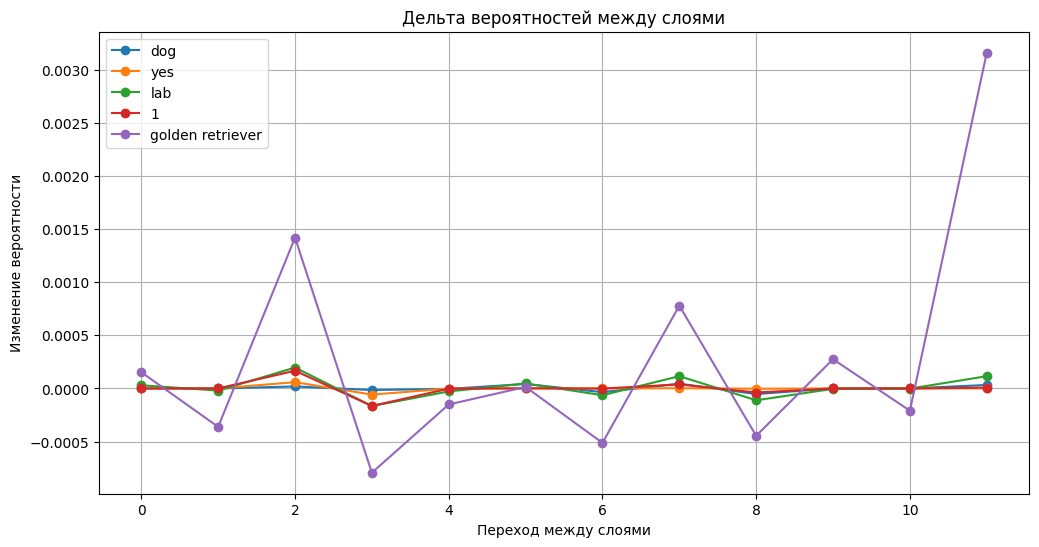

In [6]:
run_analysis()



---



Вопрос: *What animal is in the picture?*
Финальный ответ: dog (вероятность: 0.9995)
Несмотря на правильный результат, путь к нему был нетривиальным — рассмотрим,как модель постепенно "понимала" изображение.
#### Слои 0–2: фоновые объекты и шаблоны
На первых слоях активны токены, не имеющие отношения к собаке:

* siamese, slacks, persian, tuxedo, calico — намекают на кошек и одежду.
* Это визуально-ассоциативные всплески: модель находит шаблоны из обучающих данных, похожие по текстуре/форме.
* Показательны также bowtie и clydesdale, что может говорить о реакции на мех/тени.
#### Слои 3–5: консолидация образа кошки

Токены persian, calico, tuxedo продолжают доминировать.

* Это может означать, что модель временно интерпретирует животное как кошку, на основе формы ушей, взгляда, шерсти.

#### Слой 6: появление пространственного контекста

* Токены on suitcase, in suitcase, glazed впервые намекают на предметный и пространственный контекст.
* Появляется слабый сигнал awake (0.0477) и licking (0.0412), что говорит о начале осознания "живого" объекта.

#### Слой 7: переход к действиям

* Всплеск по looking out window (0.2499) и licking (0.1554).
* Модель начинает учитывать поведение объекта, а не только визуальные шаблоны.
* Начинается семантическая перестройка от описания внешности к описанию активности.

#### Слои 8–10: формирование животного поведения

* licking, sniffing, awake стабильно усиливаются.
* Это указывает на этап, где модель уже уверена: на изображении животное, ведущее себя как живое существо.
* Упоминание nursing и ski pole — вероятные шумовые ассоциации (по положению объекта).

#### Слой 12: финальная интерпретация

* Резкий скачок вероятности по awake (0.6600) — финальное закрепление "живого животного" как главного признака.
* Вероятность других токенов обнуляется или остаётся фоновой.
* Именно в этот момент происходит принципиальное уточнение категории "животное" → "собака", что мы и видим в финальном логите (dog = 0.9995).

### Логит-джампы: ключевые инсайты

| Класс                | Скачок вероятности | Слой |
| -------------------- | ------------------ | ---- |
| awake              | +0.652         | 12   |
| looking out window | +0.241             | 7    |
| on suitcase        | +0.198             | 6    |
| licking            | +0.184             | 10   |

* На слое 12 модель производит кардинальный выбор: активируется awake, который символизирует живое животное (вместо объекта/игрушки/предмета).
* looking out window — пространственно-семантический контекст: животное с намерением/взглядом.
* on suitcase — фиксация положения в кадре, важно для интерпретации позы и смысла.

## Интерпретация поведения модели

1. ViLT изначально не "знает", что это собака — она проверяет гипотезы: может быть кошка, меховая игрушка или просто часть одежды.
2. **Ключевые семантические признаки (licking, awake, sniffing) активируются на поздних слоях**, начиная с 6–7.Визуальные детали обрабатываются через линейный фильтр вероятностей, пока один из "живых" признаков не превзойдёт остальные.
4. Модель не опирается напрямую на текст вопроса («what animal») — пытается найти "животную" активность как аргумент.



## Рекомендации для дальнейшей работы
## Сравнить с другими мультимодальными моделямими (BLIP, Flamingo, Idefics, LLaVA):
   Сравнить динамику логитов и слоёв — отличаются ли пути к «пониманию»?
Изучить влияние вопроса:        
   Пример теста с другими вопросами:
   * "Is there a cat?"
   * "What color is the animal?"
   * "Is this a real dog or a toy?"
     Поможет лучше понять работу модели


 ## Анализ Attention-карт:
   Изучить, куда модель "смотрит" на изображении, особенно на слоях 6–12.

## Автоматизация логит-джампов и токен-трекинга:     
 Поможет масштабировать анализ на датасет VQA2.0 или GQA.

## Визуализировать логит-граф:
Построить логит-граф или token activation map по слоям.


